# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        #X = np.column_stack(([1 for i in range(0,len(X))],X))
        return 1/(1 +np.exp( -np.dot(X,weights.transpose())))
        
        
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        
        return 1/(len(y))*sum(np.log(1+np.exp(-np.dot(x,weights)*y)))+(1/(2*self.C))*np.amin(np.linalg.norm(weights,2))
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        loss_history = []
        for i in range(self.max_iter):
            #delta = "<your code>"  
            #delta = y*X(1 / (1 -np.exp(-np.dot(X,self.weights_.transpose())*y)))/(len(y)) - self.eta*(1/self.C)*self.weights_
            delta =  -sum((y[:,np.newaxis] * X_ext) * (1 - 1/(1 + np.exp(-np.dot(X_ext,self.weights_)*y)))[:,np.newaxis])/(len(y)) - (self.weights_/self.C) 
            self.weights_ -= self.eta * delta
            loss_history.append(self.get_loss(X_ext,self.weights_,y))
            if  (np.linalg.norm(self.eta * delta,2)) < self.tol:
                break
        return loss_history
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        if hasattr(self, 'weights_'):
            return (self.predict_proba(X) > 0.5) * 2 - 1 
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")

In [5]:
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

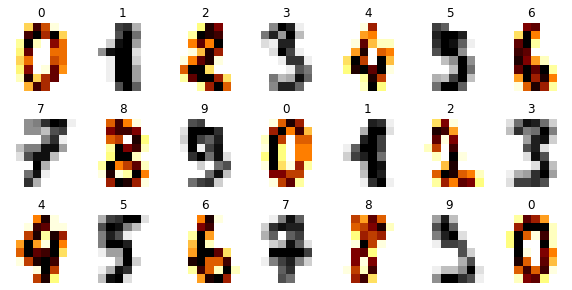

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

def fit_evaluate_no_heatplot(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
   
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

#np.set_printoptions(threshold=500000)
#print(model.predict(X_test))
#print()
#print(knn.predict(X_test))

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)


In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))
#print(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])))

In [11]:
lr_clf.fit(X_train, y_train)
#print(lr_clf.weights_)


[0.6758285235266349]

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
#lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)
#lf = SGDClassifier(max_iter=1,learning_rate = "constant",eta0 = 0.001)
#lr_clf_sklearn = LogisticRegression(max_iter=1,solver = "sgd")
#lf.fit(X_train, y_train)
#lr_clf.fit(X_train, y_train)
#assert np.allclose(lr_clf.weights_[1:],lr_clf_sklearn.coef_[0])
#print(lf.coef_[0])
#print()
#print(lr_clf.weights_[1:])

In [14]:
model = CustomLogisticRegression()

D:\Programs\Anacon\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


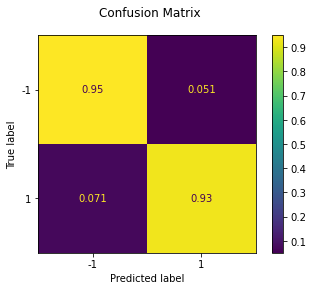

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9157967988865693, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

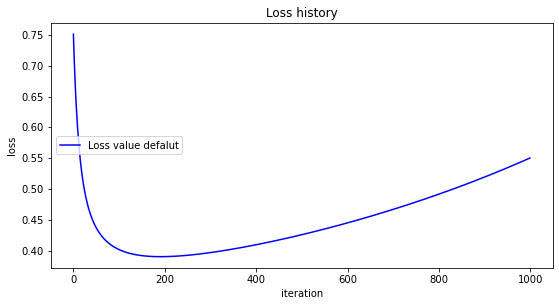

In [18]:
## your code
plt.figure(figsize=(9, 4.5))

color = ["r","b","y","g","cyan"]#Colors for figures 

model = CustomLogisticRegression()#eta=0.1
loss = model.fit(X_train, y_train)
plt.plot(range(0,len(loss)), loss, color=color[1], label='Loss value defalut')


    
plt.title("Loss history")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend(loc='center left')   
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp
D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


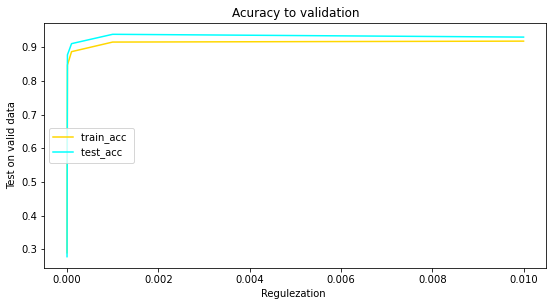

Low 0.000001 lr result : 0.2894919972164231


In [19]:
## your code
plt.figure(figsize=(9, 4.5))
rate = [0.000001,0.00001,0.0001,0.001,0.01]#0.01 is going too hight 
"""
for i in range(0,len(rate)):
    model = CustomLogisticRegression(eta=rate[i])
    loss = model.fit(X_train, y_train)
    plt.plot(range(0,len(loss)), loss, color=color[i], label='Loss value' + str(rate[i]))


    
plt.title("Loss history")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend(loc='center left')   
plt.show()
"""

train_acc_macc = []
test_acc_macc = []
n = range(1,20)
for i in rate:
    model = CustomLogisticRegression(eta = i)
    train_acc, test_acc = fit_evaluate_no_heatplot(model, X_train, y_train, X_test, y_test)
    train_acc_macc.append(train_acc)
    test_acc_macc.append(test_acc)
plt.plot(rate, train_acc_macc, color='gold', label='train_acc ')
plt.plot(rate, test_acc_macc, color='cyan', label='test_acc ')
plt.title("Acuracy to validation")
plt.xlabel("Regulezation ")
plt.ylabel("Test on valid data")
plt.legend(loc='center left')   
plt.show()
print("Low 0.000001 lr result :",train_acc_macc[0])

        Zero result is plt history.As we sea tr_acc and ts_acc became more near with more hight lr.And another intersting fact on low lr like 0.000001 we have bad accuracy.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp
D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp
D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


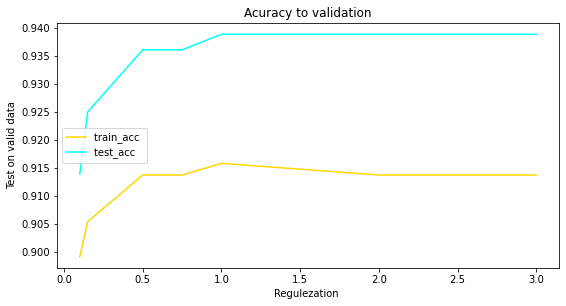

In [20]:
## your code
plt.figure(figsize=(9, 4.5))
regulezation = [0.1,0.15,0.5,0.75,1,2,3]#0.01 rate is hugher then other 
"""
for i in range(0,len(regulezation)):
    model = CustomLogisticRegression(C = regulezation[i])
    loss = model.fit(X_train, y_train)
    plt.plot(range(0,len(loss)), loss, color=color[i], label='Reguleztion value ' + str(regulezation[i]))


    
plt.title("Loss history")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend(loc='center left')   
plt.show()
"""
train_acc_macc = []
test_acc_macc = []
n = range(1,20)
for i in regulezation:
    model = CustomLogisticRegression(C = i)
    train_acc, test_acc = fit_evaluate_no_heatplot(model, X_train, y_train, X_test, y_test)
    train_acc_macc.append(train_acc)
    test_acc_macc.append(test_acc)
plt.plot(regulezation, train_acc_macc, color='gold', label='train_acc ')
plt.plot(regulezation, test_acc_macc, color='cyan', label='test_acc ')
plt.title("Acuracy to validation")
plt.xlabel("Regulezation ")
plt.ylabel("Test on valid data")
plt.legend(loc='center left')   
plt.show()

        Influence of regulization on result is not so big,but the lower regulezation parametr the low accuracy we have.

**(0.5 points)** Compare zero initialization and random initialization. 

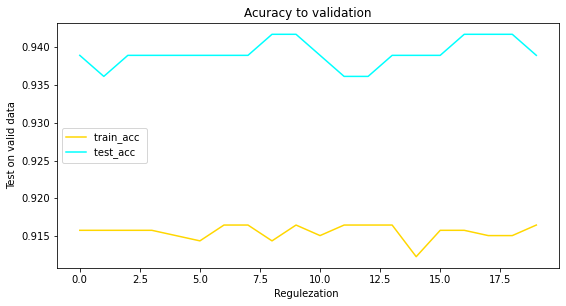

In [21]:
## your code
plt.figure(figsize=(9, 4.5))
seed = [0,1,10,100]#0.01 rate is hugher then other 
"""
model = CustomLogisticRegression(zero_init = True)
loss = model.fit(X_train, y_train)
plt.plot(range(0,len(loss)), loss, color=color[0], label='Zero init ')



for i in range(0,len(seed)):
    model = CustomLogisticRegression(random_state = seed[i])
    loss = model.fit(X_train, y_train)
    plt.plot(range(0,len(loss)), loss, color=color[i+1], label='Seed value ' + str(seed[i]))


    
plt.title("Loss history")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend(loc='center left')   
plt.show()
"""

train_acc_macc = []
test_acc_macc = []
n = range(0,20)
model = CustomLogisticRegression(zero_init = True)
train_acc, test_acc = fit_evaluate_no_heatplot(model, X_train, y_train, X_test, y_test)
train_acc_macc.append(train_acc)
test_acc_macc.append(test_acc)
for i in n[1:]:
    model = CustomLogisticRegression(random_state = i)
    train_acc, test_acc = fit_evaluate_no_heatplot(model, X_train, y_train, X_test, y_test)
    train_acc_macc.append(train_acc)
    test_acc_macc.append(test_acc)
    
plt.plot( n, train_acc_macc, color='gold', label='train_acc ')
plt.plot( n, test_acc_macc, color='cyan', label='test_acc ')
plt.title("Acuracy to validation")
plt.xlabel("Regulezation ")
plt.ylabel("Test on valid data")
plt.legend(loc='center left')   
plt.show()

    Compared zero initialization and random initialization.Influence of initialization is very low on result.(Accurace)

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [22]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        from sklearn.metrics import pairwise_distances
        return pairwise_distances(X,Y)
        #return np.sqrt( -2 * X.dot(Y.T) + sx + sy.T)#That
        
        
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>'
        p = []
        for i in self.classes_:
            p.append(sum(weights[np.where(y == i)]))
        print(p)
        return p
        
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/( P + self.eps)
            #else:
                #weights_of_points = P
            # <your code>
            result =  np.zeros((len(P),len(self.classes_)))#Result vector
            nearest = np.argsort(weights_of_points)#Sorting 
            mass_of_classes_prd = np.array([self.y[i] for i in nearest])#
            mass_of_classes_prd = mass_of_classes_prd[:,- self.n_neighbors:]
            nearest = np.sort(weights_of_points)[:,- self.n_neighbors:]
            #print(nearest)
            #print(nearest)
            for i in range(0,len(mass_of_classes_prd)): 
                weights_iter = nearest[i]
                sum_of_weights = sum(weights_iter)
                #print(sum_of_weights)
                unique, counts = np.unique(mass_of_classes_prd[i], return_counts=True)
                #print(unique, counts)
                if counts[0] == self.n_neighbors:
                    result[i,unique[0]] = 1
                else:
                    for j in range(0,len(unique)):
                        indexses = np.where(mass_of_classes_prd[i] == unique[j])
                        result[i,unique[j]] = sum(weights_iter[indexses])/sum_of_weights
                #result[count,np.argmax(counts)] = 1
            return result
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/( P + self.eps)
            #else:
                #weights_of_points = P
            # <your code>
            result =  np.array([])#Result vector
            nearest = np.argsort(weights_of_points)#Sorting 
            mass_of_classes_prd = np.array([self.y[i] for i in nearest])#
            mass_of_classes_prd = mass_of_classes_prd[:,- self.n_neighbors:]
            nearest = np.sort(weights_of_points)[:,- self.n_neighbors:]
            #print(nearest)

            for i in range(0,len(mass_of_classes_prd)): 
                vector = np.zeros(self.classes_.shape)
                weights_iter = nearest[i]
                sum_of_weights = sum(weights_iter)
                #print(sum_of_weights)
                unique, counts = np.unique(mass_of_classes_prd[i], return_counts=True)
                #print(unique, counts)
                if counts[0] == self.n_neighbors:
                    result = np.append(result,self.classes_[unique[0]])
                else:
                    for j in range(0,len(unique)):
                        indexses = np.where(mass_of_classes_prd[i] == unique[j])
                        vector[unique[j]] = sum(weights_iter[indexses])/sum_of_weights
                    #print(vector)
                    #print()
                    #print(self.classes_[np.argmax(vector)])
                    result = np.append(result,self.classes_[np.argmax(vector)])
            return result
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
        
       # return  

In [23]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [24]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))


In [25]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))


[2, 4, 0]


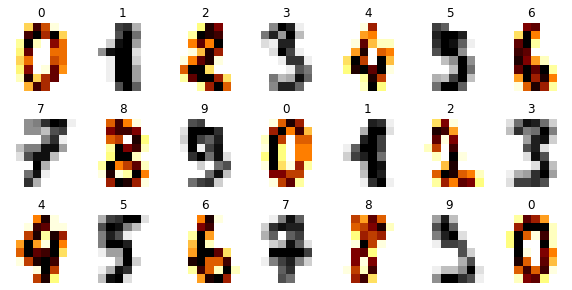

In [26]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [27]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));
#print(y_train)

In [28]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

D:\Programs\Anacon\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


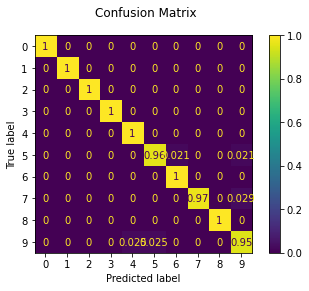

1.0 0.9861111111111112


D:\Programs\Anacon\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


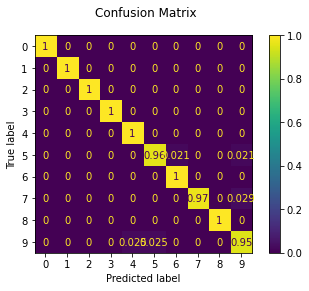

1.0 0.9861111111111112


In [29]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(train_acc,test_acc)
train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)
print(train_acc,test_acc)

In [30]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

    Second nein is bad writed so it loks like four or five, and i cant uderstand why 6 and five have conection.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

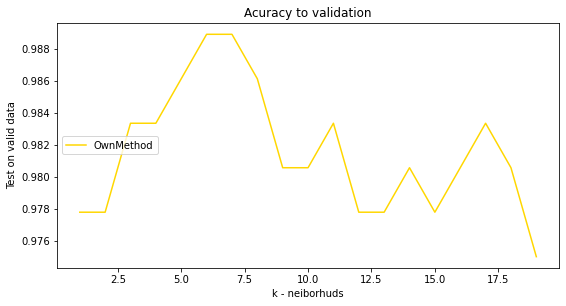

In [31]:
## your code
train_acc_macc = []
test_acc_macc = []
train_acc_knn_mass = []
test_acc_knn_mass = []
n = range(1,20)

for i in n:
    model = CustomKNeighborsClassifier(n_neighbors=i, weights='distance')
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    train_acc, test_acc = fit_evaluate_no_heatplot(model, X_train, y_train, X_test, y_test)
    train_acc_knn, test_acc_knn = fit_evaluate_no_heatplot(knn, X_train, y_train, X_test, y_test)
    train_acc_macc.append(train_acc)
    test_acc_macc.append(test_acc)
    train_acc_knn_mass.append(train_acc_knn)
    test_acc_knn_mass.append(test_acc_knn)
    
    
plt.figure(figsize=(9, 4.5))
#plt.plot(n, train_acc_macc, label='Training')It always 1
plt.plot(n, test_acc_macc, color='gold', label='OwnMethod')
#plt.plot(n, train_acc_knn_mass, label='Training')It always 1
#plt.plot(n, test_acc_knn_mass, color='cyan', label='Build_method')#its like mine))

plt.title("Acuracy to validation")
plt.xlabel("k - neiborhuds")
plt.ylabel("Test on valid data")
plt.legend(loc='center left')   
plt.show()


    For some reason best score have 6 and 7,before it score is worse,and after that it going down.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [32]:
## your code


< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

PATH = "./data/"

In [34]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [35]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

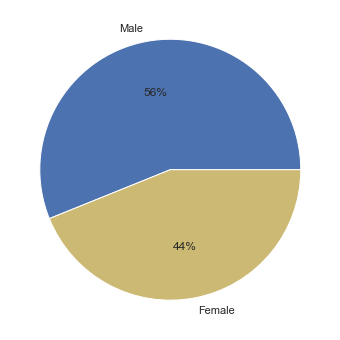

Male on board: 56114 
Female on board: 43886


In [36]:
## your code
sns.set(rc = {'figure.figsize':(6,6)})
data_sex = [len(data[data.Sex == "male"]),len(data[data.Sex == "female"])]
labels = ['Male', 'Female']
#print(len(data_titanic) - len(data_titanic[data_titanic.Survived == True]) - len(data_titanic[data_titanic.Survived == False]))
plt.pie(data_sex, labels = labels, colors = ["b","y"], autopct='%.0f%%')
plt.show()
print("Male on board: " + str(data_sex[0]),"\nFemale on board: " + str(data_sex[1]))

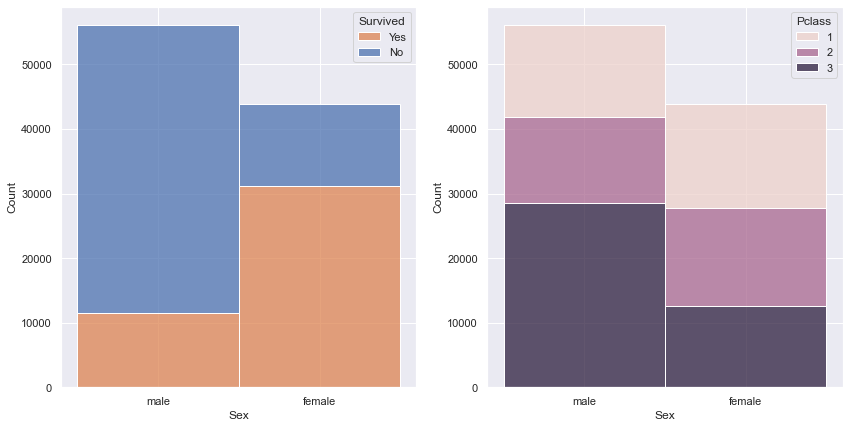

In [37]:



sns.set(rc = {'figure.figsize':(14,7)})
fig, axs = plt.subplots(ncols=2)

a = sns.histplot(data= data,
             x="Sex",
             ax = axs[0],
             hue = "Survived",
             multiple="stack" ,
             #legend=False,
             discrete=True)
a.legend(title='Survived', labels=['Yes', 'No'])
sns.histplot(data= data,
             x="Sex",
             ax = axs[1],
             hue = "Pclass",
             multiple="stack" ,
             discrete=True)

plt.show()

        Yep,more female survived.Mostly becouse of capitan say that women must be rescued.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Median age:  39.0
Median age of survived:  43.0
Median age of dead:  36.0


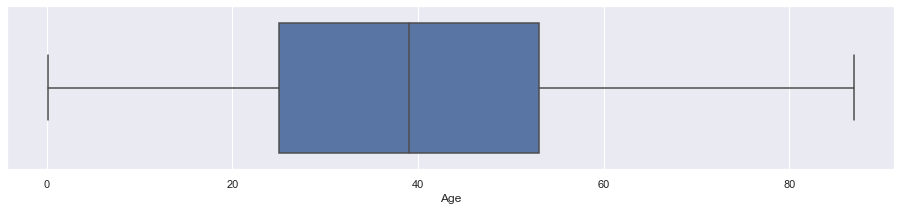

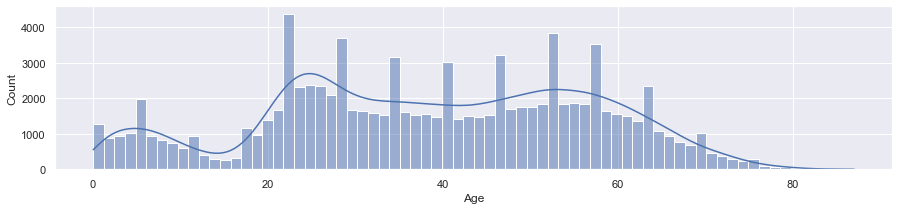

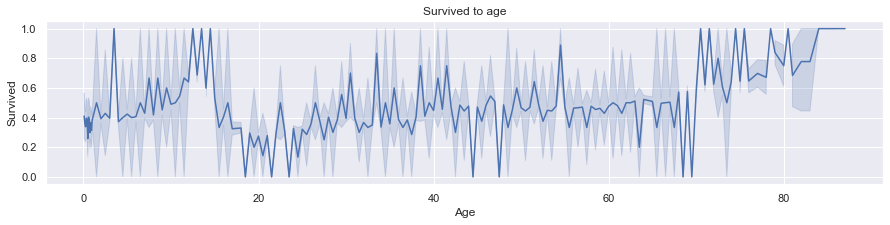

In [38]:
## your code
print("Median age: ",data.Age.median())
print("Median age of survived: ",data.Age[data.Survived == True].median())
print("Median age of dead: ",data.Age[data.Survived == False].median())
sns.set(rc = {'figure.figsize':(15.9,3)})
sns.boxplot(x = data.Age)
plt.show()
sns.set(rc = {'figure.figsize':(15,3)})
sns.histplot(data['Age'],kde=True) 
plt.show()

ax = sns.lineplot(data = data[["Age","Survived"]],
             x = "Age",
             y = "Survived",
             markers=True,
             dashes=False)
ax.set_title('Survived to age')
plt.show()

    The oldest and the yanger survived the more.Median age is 39.(for sur 43 and for not surv 36)

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

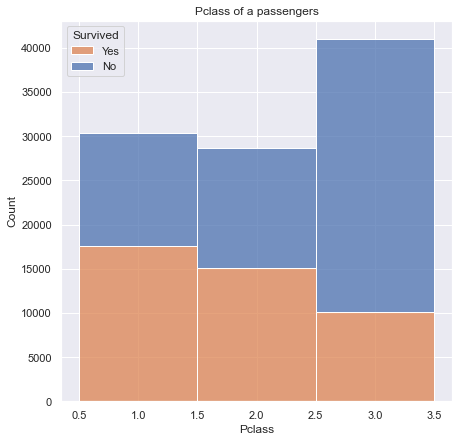

In [39]:
## your code
"""ax = sns.lineplot(data = data[["Age","Pclass"]],
             x = "Age",
             y = "Pclass",
             #hue = "Pclass",
             markers=True,
             dashes=False)
ax.set_title('Age to class of passengers')
plt.show()
"""
sns.set(rc = {'figure.figsize':(7,7)})
ax = sns.histplot(data=data,
             x="Pclass",
             hue = "Survived",
             multiple="stack" ,
             discrete=True)
ax.legend(title='Survived', labels=['Yes', 'No'])
ax.set_title('Pclass of a passengers')
plt.show()


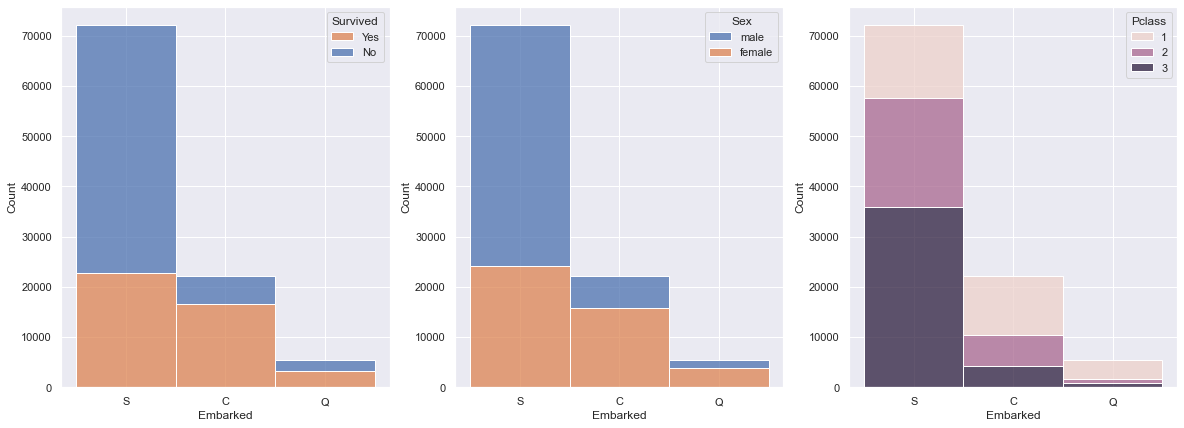

In [40]:
sns.set(rc = {'figure.figsize':(20,7)})
fig, axs = plt.subplots(ncols=3)
a = sns.histplot(data= data,
             x="Embarked",
             hue = "Survived",
             multiple="stack" ,
             ax = axs[0],
             discrete=True)
a.legend(title='Survived', labels=['Yes', 'No'])

sns.histplot(x="Embarked",
            hue="Sex",
            data= data,
            ax = axs[1],
            multiple="stack")

sns.histplot(x="Embarked",
            hue="Pclass",
            data= data,
            ax = axs[2],
            multiple="stack")
plt.show()

      That's very strange,but if you embarked in "Queenstown" or "Cherbourg" you could survive,we need to analyze this some another colums to understand ulogical connection.
      The first thing we see is that the 1st histogram and the 2nd histogram are very similar.This suggests that the port of departure approximately coincides with the gender of passengers.   
      We also see that in the third case, the columns corresponding to the second and third ports have the largest percentage of the first class, which can determine the 1st histogram

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

<AxesSubplot:xlabel='PassengerId'>

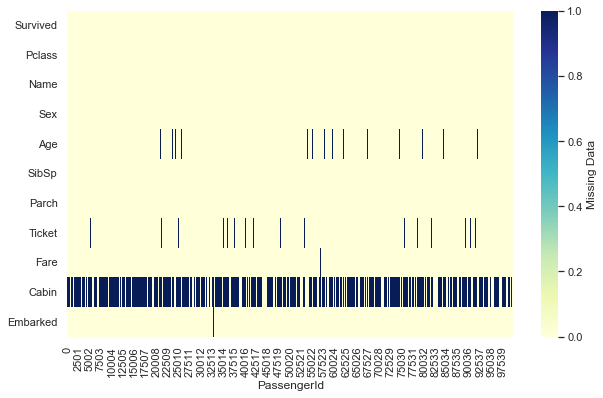

In [41]:
## your code
plt.figure(figsize=(10,6))
sns.heatmap(data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})


    Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?
    
    The easiest way to solve the problem of missing data is to get rid of the column, but this is not the best option when we have few columns, the second option is to generate data on the rest of the groups for other data. When a large amount of data is missing in a column, you can use the tactic of missing data is also data


**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [42]:
## your code
#data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [43]:
Sex_data = pd.DataFrame({'Sex': ["male", "female"], 'Sex_id': [0, 1]})
data = data.merge(Sex_data,left_on = "Sex" 
                                                  ,right_on = "Sex" 
                                                  ,how = "left" )
data.drop(axis=1, index=None, columns=["Sex"],inplace=True)

In [44]:
Embark_data = pd.DataFrame({'Embarked': ["S", "Q","C"], 'Embark_id': [0, 1, 2]})
data = data.merge(Embark_data,left_on = "Embarked" 
                                                  ,right_on = "Embarked" 
                                                  ,how = "left" )
Embark_data = pd.DataFrame({'Embarked': ["Southampton", "Queenstown","Cherbourg"], 'Embark_id': [0, 1, 2]})
data.drop(axis=1, index=None, columns=["Embarked"],inplace=True)

In [45]:
data["Cabin"][data.Cabin.notna()] = 1
data["Cabin"] = data["Cabin"].fillna(0)

D:\Programs\Anacon\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
data["Embark_id"] = data["Embark_id"].fillna(str(data.Embark_id.mode()[0]))

In [47]:
data["Age"] = data["Age"].fillna(round(data["Age"].mean(),0))
'''
data['Age_grup'] = 0
data['Age_grup'] [data.Age <= 1] = 1
data['Age_grup'] [(data.Age > 1) & (data.Age <= 7)] = 2
data['Age_grup'] [(data.Age > 7) & (data.Age <= 18)] = 3
data['Age_grup'] [(data.Age > 18) & (data.Age <= 30)] = 4
data['Age_grup'] [(data.Age > 30) & (data.Age <= 50)] = 5
data['Age_grup'] [(data.Age > 50) & (data.Age <= 70)] = 6
data['Age_grup'] [data.Age > 70] = 1
'''
#age grouping didt help(its usless becouse of age have more variants)
"""So going on"""

#data["Parch"][data.Parch > 0] = 1 # didnt help to incasise the result

'So going on'

In [48]:
data["Fare"] = data["Fare"].fillna(data["Fare"].mean())

<AxesSubplot:>

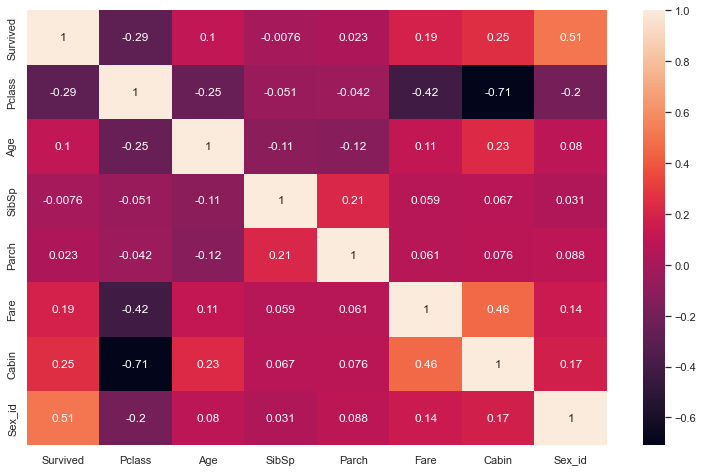

In [49]:
sns.set(rc = {'figure.figsize':(13,8)})
sns.heatmap(data.corr(), annot=True)

In [50]:
features = ["Sex_id","Age","Embark_id","Cabin","Fare","Pclass"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data[features],
                                                    data.Survived,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [52]:
## your code
knn = KNeighborsClassifier(n_neighbors=18, weights='distance')
#knn = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
#not working becouse "Unable to allocate 11.9 GiB for an array with shape (20000, 80000) and data type float64"
lr_clf = LogisticRegression(max_iter = 40000,penalty = "l2",C = 0.001)

D:\Programs\Anacon\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


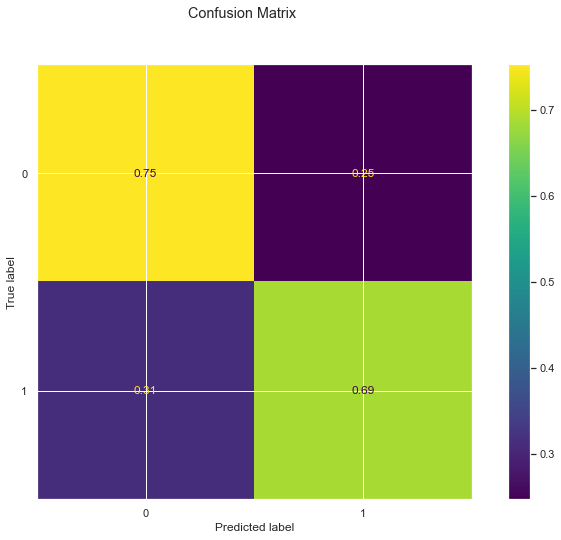

0.93763

In [53]:
knn.fit(X_train, y_train)
knn.predict(X_test)
knn.fit(X_train, y_train)
disp = metrics.plot_confusion_matrix(knn, X_test, y_test, normalize='true')
disp.figure_.suptitle("Confusion Matrix")
plt.show()
    
metrics.accuracy_score(y_pred=knn.predict(X_train), y_true=y_train), \

metrics.accuracy_score(y_pred=knn.predict(X_test), y_true=y_test)

metrics.accuracy_score(y_pred=knn.predict(data[features]), y_true=data["Survived"])


D:\Programs\Anacon\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


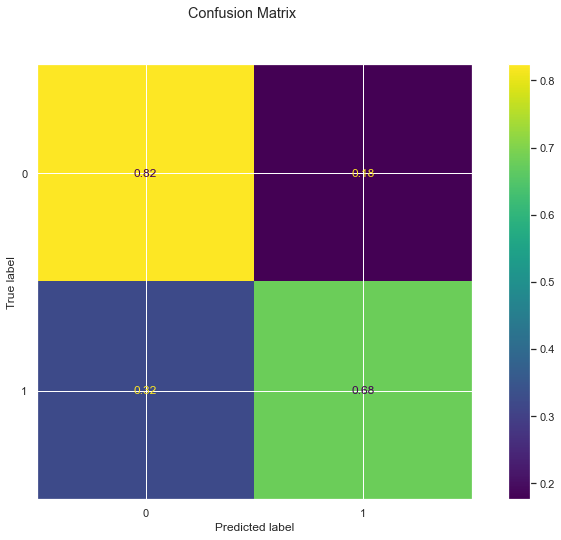

0.76316

In [54]:


lr_clf.fit(X_train, y_train)
lr_clf.predict(X_test)
lr_clf.fit(X_train, y_train)
disp = metrics.plot_confusion_matrix(lr_clf, X_test, y_test, normalize='true')

disp.figure_.suptitle("Confusion Matrix")
plt.show()
    
metrics.accuracy_score(y_pred=lr_clf.predict(X_train), y_true=y_train), \
metrics.accuracy_score(y_pred=lr_clf.predict(X_test), y_true=y_test)

metrics.accuracy_score(y_pred=lr_clf.predict(data[features]), y_true=data["Survived"])

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [55]:
pred=lr_clf.predict(data[features])

f = pd.DataFrame(data = pred,columns = ["Survived"]).reset_index()
f = f.rename(columns={"index": "PassengerId"})
#f.rename("PassengerId",inplace = True)

#f.apply(=100001)
f['PassengerId'] = f['PassengerId'].apply(lambda x: x +100000)
f.to_csv('n_out.csv', index=False)

#metrics.accuracy_score(y_pred=f["Survived"], y_true=data["Survived"])